# Import dependencies

In [1]:
# Data manipulation and image importation
import numpy as np 
import pandas as pd 
from PIL import Image

# For splitting the dataset
from sklearn.model_selection import train_test_split


# Libraries for the construction of the CNN model
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# Various purposes
import os
import datetime # Get start time and end time
import random # Self-explanatory library

# Plotting and visualizing
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Save the starting time of the notebook
start_time = datetime.datetime.now()

2024-04-03 21:05:44.948502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 21:05:46.096918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!nvidia-smi

Wed Apr  3 21:05:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:2D:00.0  On |                  N/A |
| 30%   49C    P3             N/A /  115W |    1735MiB /   8188MiB |     40%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Define the necessary functions. We will keep it at the top to find them easier

In [3]:
def get_dataset(directory,type_of_data="train",IMAGE_SIZE=(48,48),num_classes=43):
    X = [] # images flowing from directory
    y = [] # labels flowing from directory
    
    # Iterate through image folders
    for i in range(num_classes):
        path = os.path.join(directory,type_of_data,str(i)) 
        
        # List all the images in the folder
        for j in os.listdir(path):  
            
            # Open the image
            image = Image.open(path + '/'+ j) 
            
            # Resize it to (48,48)
            image = image.resize(IMAGE_SIZE) 
            
            # Convert it to a numpy array for easier use
            image = np.array(image) 
            
            # Add the image and the labels to the lists
            X.append(image) 
            y.append(i)
            
    return np.array(X), np.array(y)


In [4]:
def plot_label_distribution(labels, class_names):
    """
    Plots the distribution of images across different labels.

    Parameters:
    labels (array-like): Array of labels corresponding to the images.
    class_names (list): List of class names.

    Returns:
    None
    """
    # Convert labels to numpy array if not already
    labels = np.array(labels)

    # Count the number of images for each label
    label_counts = np.bincount(labels)

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, label_counts)
    plt.xlabel('Class Name')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images Across Classes')
    plt.xticks(rotation=90)  # Rotate x-axis labels to vertical orientation
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [5]:
def plot_confusion_matrix(true_values, predicted_values, classes, save_figure=False, filename=None, figsize=(8, 6)):
    """
    Plots a confusion matrix for a deep neural network.

    Parameters:
    true_values (array-like): Array of true class labels.
    predicted_values (array-like): Array of predicted class labels.
    classes (list): List of class names.
    save_figure (bool): Whether to save the figure or not.
    filename (str): Filename to save the figure (if save_figure is True).
    figsize (tuple): Size of the figure (width, height).
    
    Returns:
    None
    """
    # Compute confusion matrix
    cm = confusion_matrix(true_values, predicted_values)
    
    # Plot confusion matrix
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize":10})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save the figure if specified
    if save_figure and filename:
        plt.savefig(filename)
    
    plt.show()

In [6]:
def load_image(path,rgba=False):
    """
    Load and prepare the image to predict on the model. It takes simple image,
    resizes it to (48,48), transforms it into an numpy array and expands it to be
    in shape (None,48,48,3) in order to be used by our model
    path: path to the image used
    rgba: set if the image has an alpha channel, it converts the image to rgb
    
    """
    
    loaded_image = Image.open(path)
    if rgba:
        loaded_image = loaded_image.convert("RGB")
    loaded_image = loaded_image.resize((48,48))
    loaded_image = np.array(loaded_image)
    loaded_image = np.expand_dims(loaded_image,axis=0)
    return loaded_image

In [7]:

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

# Import data from train
# Separate it into images of (48,48) and labels

In [8]:
# Define the variables

directory = "gtsrb_traffic_sign/"
IMAGE_SIZE = (96,96)
SMALL_IMAGE_SIZE = (48,48) # We will use this one
num_classes = 43

In [9]:
# Some signs might differ.
# Please check the Meta folder for the corresponding signs

sign_names = ["limit_zone_20","limit_zone_30","limit_zone_50","limit_zone_60","limit_zone_70",
              "limit_zone_80","end_of_speed_limit","limit_zone_100","limit_zone_120",
              "no_passing","no_passing_for_trucks","right_of_way","priority_road",
              "yield_right_of_way","stop","prohibited_for_all_vehicles","tractors_and_trucks_prohibited",
              "entry_prohibited","danger","single_curve_left","single_curve_right","double_curve",
              "rough_road","slippery_road","road_narrows","construction_site","signal_lights_ahead","pedestrian_crosswalk_ahead",
              "children","bicycle_crossing","snow_ahead","wild_animal_crossing","end_of_all_restrictions",
               "mandatory_right","mandatory_left","mandatory_ahead","mandatory_ahead_right",
              "mandatory_ahead_left","mandatory_down_right","mandatory_down_left","traffic_circle","end_of_no_passing_zone",
              "end_of_no_passing_zone_trucks"]

In [10]:
# Get the data from
train_data, train_labels = get_dataset(directory=directory,
                                      type_of_data="train",
                                      IMAGE_SIZE=SMALL_IMAGE_SIZE,
                                      num_classes=num_classes)

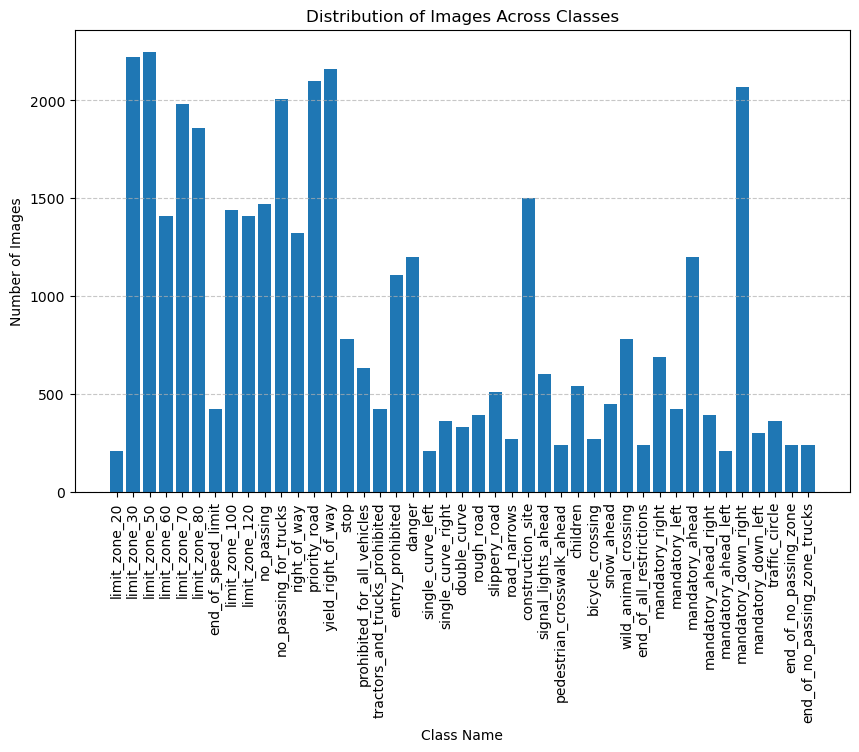

In [11]:
plot_label_distribution(train_labels,sign_names)

# Split the dataset into train/validation

limit_zone_30


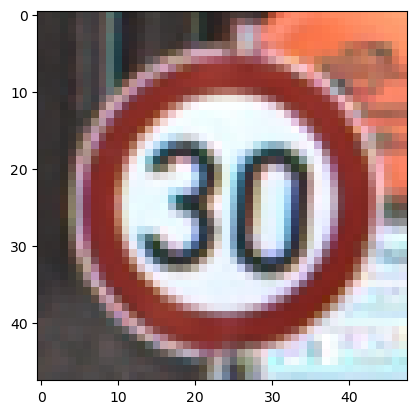

In [12]:
print(sign_names[train_labels[2000]])
plt.imshow(train_data[2000])

In [13]:
# Split the data into training/validation
x_train, x_valid, y_train, y_valid = train_test_split(train_data, 
                                                    train_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)


In [14]:
# Encode the labels
# Thus, every label holds information about which class the image is 
# And also all the classes that it is not


y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)

construction_site


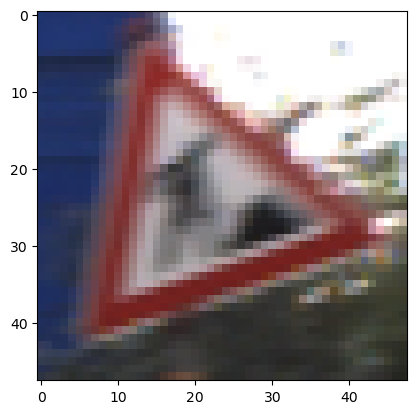

In [15]:
print(sign_names[np.argmax(y_train[2000])])
plt.imshow(x_train[2000])

In [16]:
print(f"The shape of our training data: {x_train.shape}")
print(f"The shape of our training labels: {y_train.shape}")
print(f"The shape of our validation data: {x_valid.shape}")
print(f"The shape of our validation images: {y_valid.shape}")
print(f"One of our labels: {y_valid[0]}")

The shape of our training data: (31367, 48, 48, 3)
The shape of our training labels: (31367, 43)
The shape of our validation data: (7842, 48, 48, 3)
The shape of our validation images: (7842, 43)
One of our labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Create two datasets for faster processing of data

In [17]:
# Create datasets for faster processing
# In this way, we will be able to fetch data gradually into out model
# Convert each type of data into a Dataset, and then zip them together

train_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(x_train),
    tf.data.Dataset.from_tensor_slices(y_train)
))

valid_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(x_valid),
    tf.data.Dataset.from_tensor_slices(y_valid)
))

# Normalize images. Pixels thus take values from [0,255] -> [0,1]
# The model works faster with floats between 0 and 1

def normalize_img(image,label):
    return tf.cast(image,tf.float32)/255., label

#Apply normalization and prefetching
train_dataset = train_dataset.map(normalize_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.map(normalize_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


2024-04-03 21:08:10.170643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 21:08:10.389256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 21:08:10.389345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 21:08:10.391793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 21:08:10.391888: I external/local_xla/xla/stream_executor

The reason we first import the data, split it, and the put it together in two datasets is because we want the images to be shuffled correctly and to keep their respective labels. We want to have examples of all classes for both training and validation. Further more, we convert the data into tensorflow datasets. This allows us to prefetch elements (feed them gradually into the model, and thus reduce memory usage) and to normalize each image between [0.,1.] for easier processing.

# Define Callbacks for automatic tuning

In [18]:
# Create callbacks for our model
# Callbacks add functionality to our model while it is still running

# Save the best value
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.keras',  # Filepath to save the model
    monitor='val_loss',               # Quantity to monitor
    save_best_only=True,              # Save only the best models
    verbose=1                          # Verbosity level (0 or 1)
)


# Define a callback for reducing learning rate on plateau
# This way, when the model gets to a point where it 'stucks', it can reduce lr to refine results
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',       # Quantity to monitor
    factor=0.1,               # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=4,               # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,              # Lower bound on the learning rate
    verbose=1                 # Verbosity level (0 or 1) 
)

# Stop the model if it is not progressing
# I arbitrarily set this callback to 2 x reduce_lr_callback patience 
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=8,

)


# Define a Functional CNN Model 

In [19]:

inputs = Input(shape=(48,48,3), name="input_layer")

conv_1 = Conv2D(filters=96, kernel_size=7,activation="relu")(inputs)
max_pool_1 = MaxPool2D()(conv_1)
conv_2 = Conv2D(128, kernel_size=4,activation="relu")(max_pool_1)
max_pool_2 = MaxPool2D()(conv_2)
conv_3 = Conv2D(256, kernel_size=4,activation="relu")(max_pool_2)
max_pool_3 = MaxPool2D()(conv_3)
flat = Flatten()(max_pool_3)
dense_1 = Dense(256, activation="relu")(flat)

outputs = Dense(num_classes, activation="softmax")(dense_1)

model = tf.keras.Model(inputs,outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 42, 42, 96)     │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 18, 128)    │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,619 (5.10 MB)

 Trainable params: 1,336,619 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

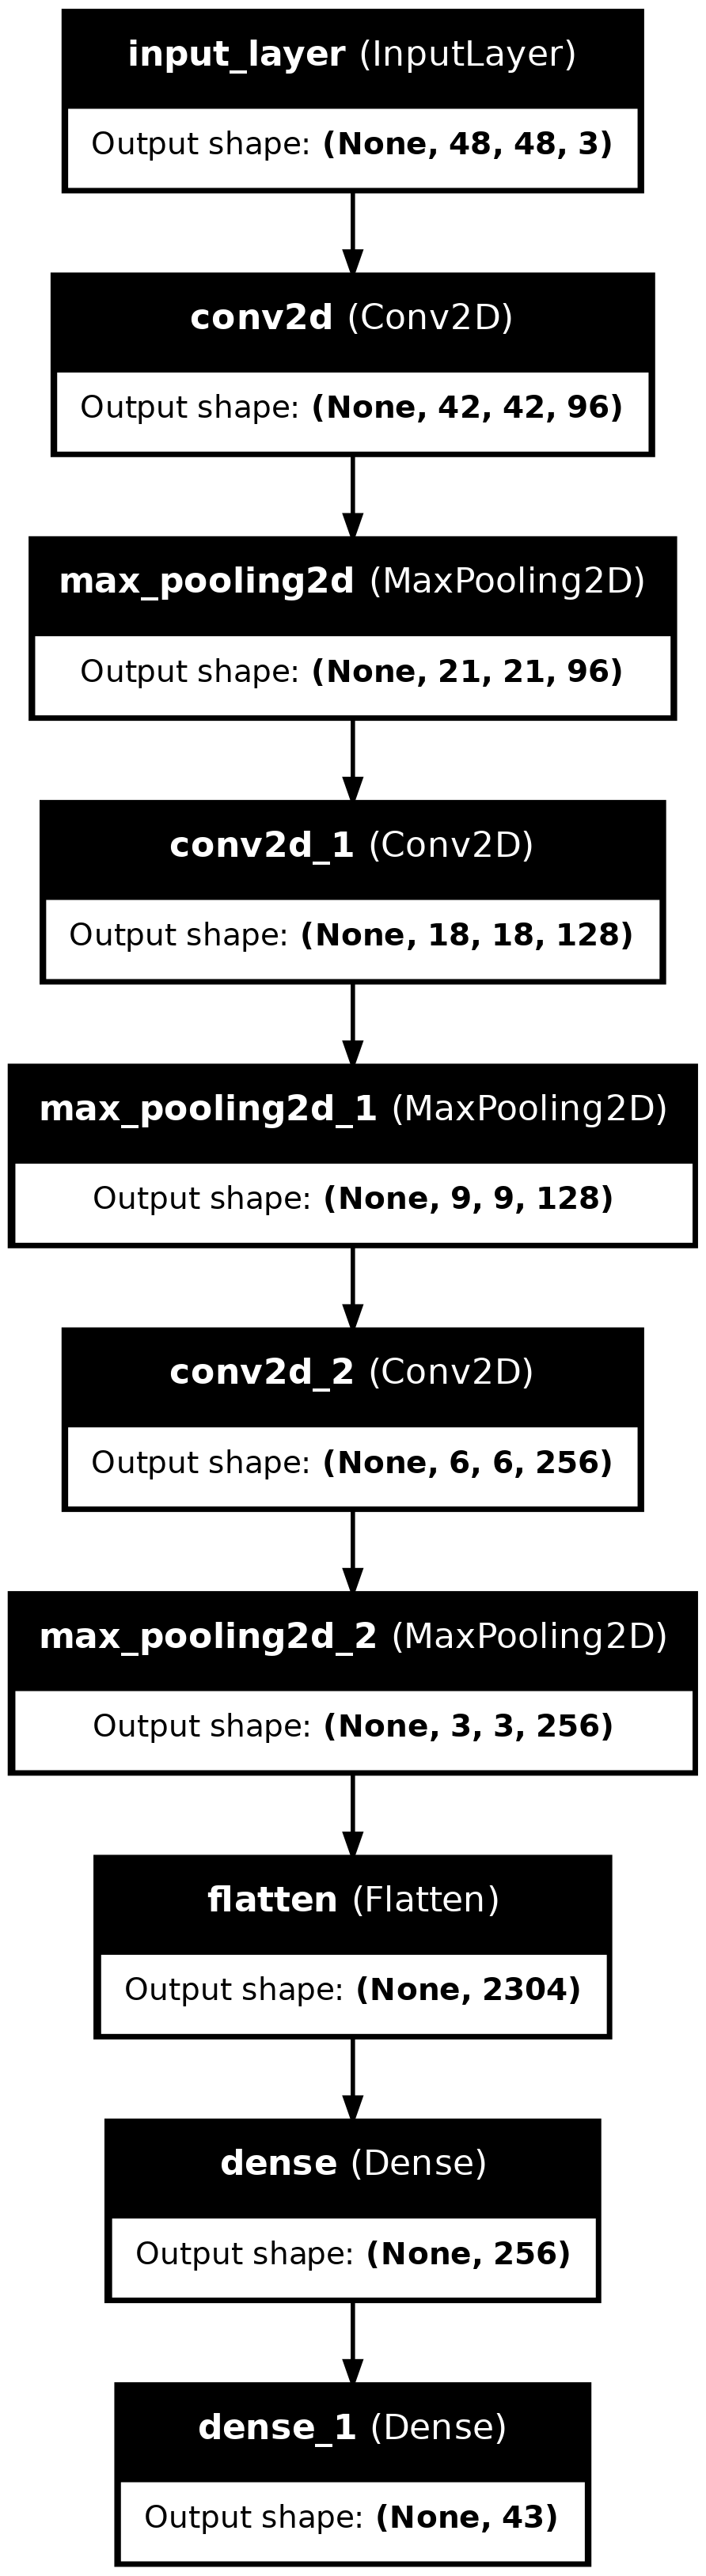

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [21]:

model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy","precision","recall"])

history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=valid_dataset,
                    callbacks=[reduce_lr_callback,early_stopping_callback,checkpoint_callback])

Epoch 1/100


I0000 00:00:1712167693.115457   35520 service.cc:145] XLA service 0x7ff24400b7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712167693.115554   35520 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-04-03 21:08:13.154960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-03 21:08:13.324954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712167694.635971   35579 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_666', 544 bytes spill stores, 544 bytes spill loads



 23/981 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0165 - loss: 3.7103 - precision: 0.0000e+00 - recall: 0.0000e+00      

I0000 00:00:1712167698.429117   35520 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


976/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4587 - loss: 1.9931 - precision: 0.7773 - recall: 0.3586

I0000 00:00:1712167707.972631   35693 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_666', 512 bytes spill stores, 512 bytes spill loads



981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4601 - loss: 1.9877 - precision: 0.7781 - recall: 0.3602
Epoch 1: val_loss improved from inf to 0.11028, saving model to model_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.4604 - loss: 1.9867 - precision: 0.7783 - recall: 0.3605 - val_accuracy: 0.9699 - val_loss: 0.1103 - val_precision: 0.9767 - val_recall: 0.9639 - learning_rate: 0.0010
Epoch 2/100
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9727 - loss: 0.1056 - precision: 0.9781 - recall: 0.9656
Epoch 2: val_loss improved from 0.11028 to 0.05335, saving model to model_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9727 - loss: 0.1056 - precision: 0.9781 - recall: 0.9656 - val_accuracy: 0.9864 - val_loss: 0.0533 - val_precision: 0.9881 - val_recall: 0.9837 - learning_rate: 0.0010
Epoch 3/100
977/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9847 - loss: 0.0524 - precision: 0.9872 - recall: 0.9827
Epoch 3: val_

975/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9951 - loss: 0.0230 - precision: 0.9952 - recall: 0.9948
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 18: val_loss did not improve from 0.03857
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9951 - loss: 0.0230 - precision: 0.9952 - recall: 0.9948 - val_accuracy: 0.9922 - val_loss: 0.0443 - val_precision: 0.9926 - val_recall: 0.9922 - learning_rate: 0.0010
Epoch 19/100
978/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0025 - precision: 0.9995 - recall: 0.9994
Epoch 19: val_loss improved from 0.03857 to 0.03348, saving model to model_checkpoint.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9994 - loss: 0.0025 - precision: 0.9995 - recall: 0.9994 - val_accuracy: 0.9954 - val_loss: 0.0335 - val_precision: 0.9955 - val_recall: 0.9954 - learning_rate: 1.0000e-04
Epoch 20/100
975/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7626e-04 - 

In [22]:
inputs = Input(shape=(48,48,3), name="input_layer")
conv_1 = Conv2D(filters=64, kernel_size=5,activation="relu")(inputs)
conv_2 = Conv2D(filters=64, kernel_size=5,activation="relu")(conv_1)
max_pool_1 = MaxPool2D()(conv_2)
conv_3 = Conv2D(48, kernel_size=3,activation="relu")(max_pool_1)
conv_4 = Conv2D(48, kernel_size=3,activation="relu")(conv_3)
max_pool_2 = MaxPool2D()(conv_4)
dropout = Dropout(0.3)(max_pool_2)
flat = Flatten()(dropout)
dense_1 = Dense(256, activation="relu")(flat)
outputs = Dense(num_classes, activation="softmax")(dense_1)
model2 = tf.keras.Model(inputs,outputs)

model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 44, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 48)     │        27,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 953,547 (3.64 MB)

 Trainable params: 953,547 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:

model2.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy","precision","recall"])

history2 = model2.fit(train_dataset,
                    epochs=100,
                    validation_data=valid_dataset,
                    callbacks=[reduce_lr_callback,early_stopping_callback,checkpoint_callback])

Epoch 1/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6242 - loss: 1.3939 - precision: 0.8603 - recall: 0.5278
Epoch 1: val_loss did not improve from 0.03338
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6244 - loss: 1.3931 - precision: 0.8604 - recall: 0.5281 - val_accuracy: 0.9758 - val_loss: 0.0917 - val_precision: 0.9812 - val_recall: 0.9707 - learning_rate: 0.0010
Epoch 2/100
978/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9725 - loss: 0.0950 - precision: 0.9782 - recall: 0.9675
Epoch 2: val_loss did not improve from 0.03338
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9726 - loss: 0.0950 - precision: 0.9782 - recall: 0.9675 - val_accuracy: 0.9857 - val_loss: 0.0593 - val_precision: 0.9881 - val_recall: 0.9843 - learning_rate: 0.0010
Epoch 3/100
976/981 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9839 - loss: 0.0516 - precision: 0.9865 - recall: 0.9826
Epoch 3: val_loss did not improve from 0.03338
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/st

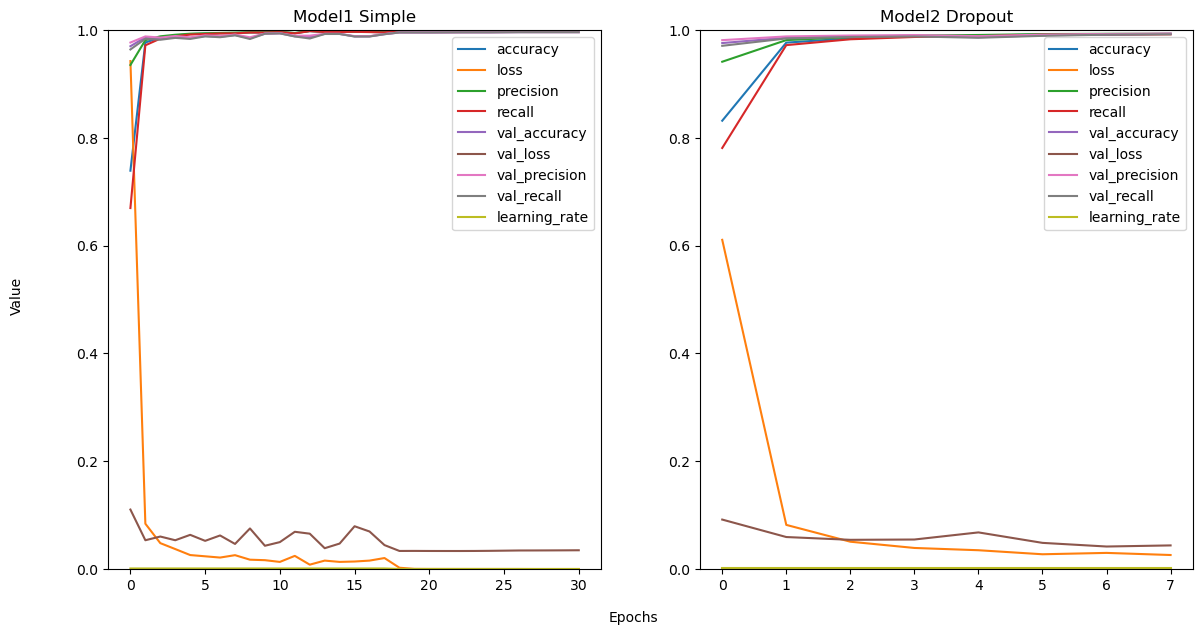

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plotting history for Model1
history_keys = list(history.history.keys())
for key in history_keys:
    axes[0].plot(pd.DataFrame(history.history[key]), label=key)
axes[0].set_title("Model1 Simple")
axes[0].set_ylim([0, 1])  # Setting y-axis limits
axes[0].legend()

# Plotting history for Model2
history2_keys = list(history2.history.keys())
for key in history2_keys:
    axes[1].plot(pd.DataFrame(history2.history[key]), label=key)
axes[1].set_title("Model2 Dropout")
axes[1].set_ylim([0, 1])  # Setting y-axis limits
axes[1].legend()

# Adding labels to the entire figure
fig.text(0.5, 0.04, 'Epochs', ha='center', va='center')
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

# Load Test Data

In [25]:
test_csv = pd.read_csv("gtsrb_traffic_sign/Test.csv",delimiter=",")
test_csv.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [26]:
imgs = test_csv["Path"]
true_labels = test_csv["ClassId"]

path = "gtsrb_traffic_sign/Test"
test_data =[]
for j in imgs:
    image = Image.open("gtsrb_traffic_sign/"+ j)
    image = image.resize((48,48))
    image = np.array(image)
    test_data.append(image)


In [27]:
test_data = np.array(test_data)
test_data.shape

(12630, 48, 48, 3)

# Predict and evaluate on the test data

In [28]:
model_preds = model.predict(test_data)
model_preds

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
y_preds = np.argmax(model_preds,axis=1)
len(y_preds)

12630

In [30]:
# Calculate the performance 
model_results = calculate_results(true_labels, y_preds)

In [31]:
model2_preds = model2.predict(test_data)
y_preds_2 = np.argmax(model2_preds,axis=1)
model2_results = calculate_results(true_labels, y_preds_2)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [32]:
model_results,model2_results

({'accuracy': 95.65320665083135,
  'precision': 0.9577312807745219,
  'recall': 0.9565320665083136,
  'f1': 0.9559354496828387},
 {'accuracy': 95.60570071258907,
  'precision': 0.9574911394462366,
  'recall': 0.9560570071258907,
  'f1': 0.9557825808115633})

# Visualize the predictions

Df before transpose:
            simple_model  dropout_model
accuracy      95.653207      95.605701
precision      0.957731       0.957491
recall         0.956532       0.956057
f1             0.955935       0.955783
Df after transpose:
                 accuracy  precision    recall        f1
simple_model   95.653207   0.957731  0.956532  0.955935
dropout_model  95.605701   0.957491  0.956057  0.955783


Text(0.5, 1.0, 'Model results comparison')

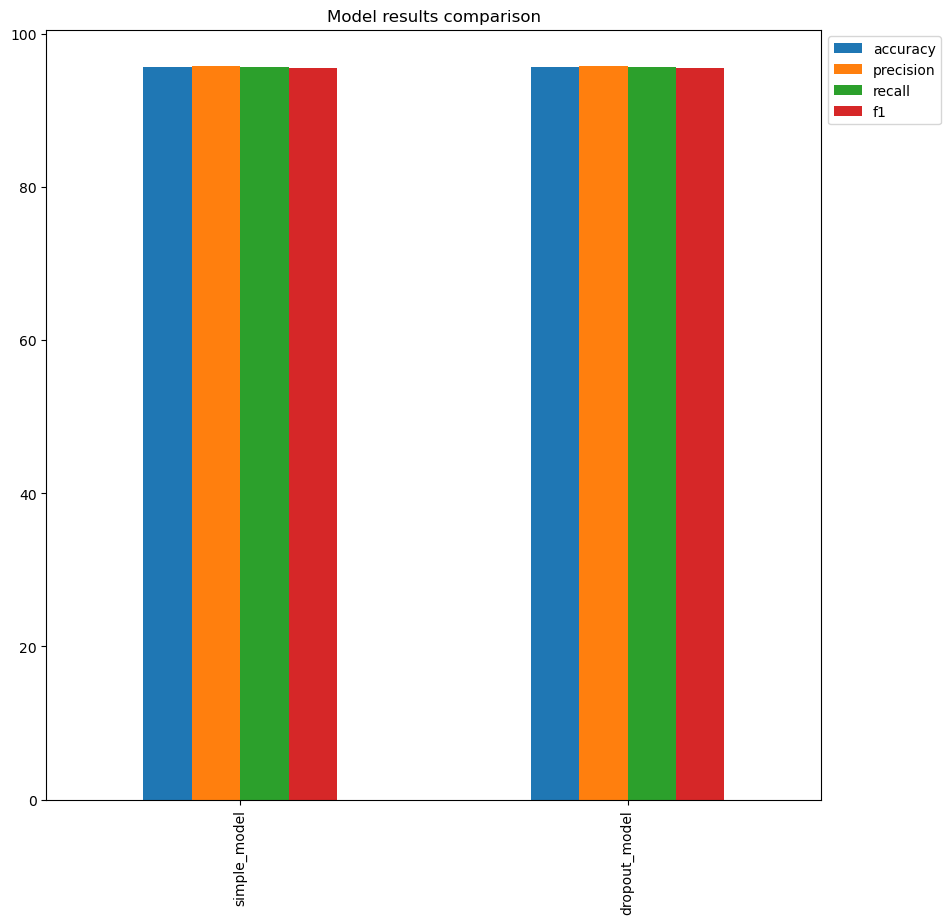

In [33]:
# Create a dictionary with all the results
all_results = {
    "simple_model":model_results,
    "dropout_model":model2_results,
}

# Transform the dictionary into a pandas dataframe
df_all_results = pd.DataFrame(all_results)
print(f"Df before transpose:\n {df_all_results}")
df_all_results = df_all_results.transpose()
print(f"Df after transpose:\n {df_all_results}")

# Plot the results
# Be careful when you copy the multiplication by 100 into a separate cell if you run this
# In a Jupyter Notebook, it will keep multiplying it by 100 indefinetly

df_all_results["precision"] = df_all_results["precision"]*100
df_all_results["recall"] = df_all_results["recall"]*100
df_all_results["f1"] = df_all_results["f1"]*100
df_all_results.plot(kind="bar", figsize=(10,10)).legend(bbox_to_anchor=(1.0,1.0))
plt.title("Model results comparison")

# Make Custom Predictions
## Our model might have problems identifying some images
### It is recommended to add image augmentation to training images in order to increase it's performance. 

In [34]:
image1 = load_image("custom_image.jpg")
image2 = load_image("50_zone.jpg")
image3 = load_image("right_of_way.png", rgba=True)
image4 = load_image("stop.png",rgba=True)
image5 = load_image("danger.png",rgba=True)
image6 = load_image("give_priority.png",rgba=True)
image7 = load_image("road_priority_.png",rgba=True)

prediction1 = np.argmax(model.predict(image1))
prediction2 =np.argmax(model.predict(image2))
prediction3 =np.argmax(model.predict(image3))
prediction4 =np.argmax(model.predict(image4))
prediction5 = np.argmax(model.predict(image5))
prediction6 =np.argmax(model.predict(image6))
prediction7 =np.argmax(model.predict(image7))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


(-0.5, 47.5, 47.5, -0.5)

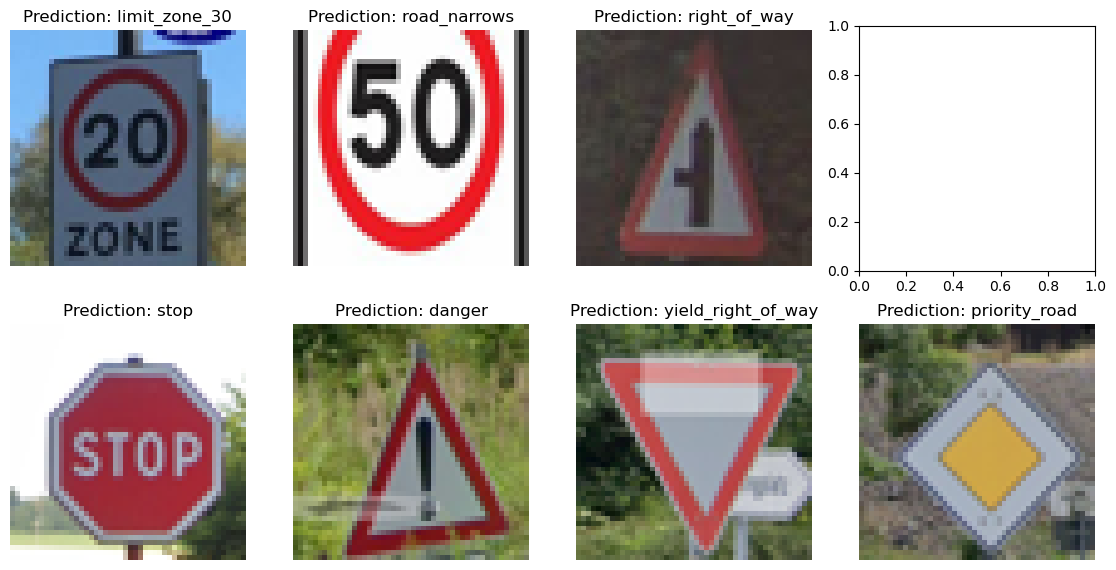

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(14,7))

axes[0,0].imshow(np.squeeze(image1))
axes[0,0].set_title(f"Prediction: {sign_names[prediction1]}")
axes[0,0].axis(False)

axes[0,1].imshow(np.squeeze(image2))
axes[0,1].set_title(f"Prediction: {sign_names[prediction2]}")
axes[0,1].axis(False)

axes[0,2].imshow(np.squeeze(image3))
axes[0,2].set_title(f"Prediction: {sign_names[prediction3]}")
axes[0,2].axis(False)


axes[1,0].imshow(np.squeeze(image4))
axes[1,0].set_title(f"Prediction: {sign_names[prediction4]}")
axes[1,0].axis(False)

axes[1,1].imshow(np.squeeze(image5))
axes[1,1].set_title(f"Prediction: {sign_names[prediction5]}")
axes[1,1].axis(False)

axes[1,2].imshow(np.squeeze(image6))
axes[1,2].set_title(f"Prediction: {sign_names[prediction6]}")
axes[1,2].axis(False)

axes[1,3].imshow(np.squeeze(image7))
axes[1,3].set_title(f"Prediction: {sign_names[prediction7]}")
axes[1,3].axis(False)

In [36]:
confusion_matrix(true_labels.values, y_preds)

array([[ 60,   0,   0, ...,   0,   0,   0],
       [  0, 716,   1, ...,   0,   0,   0],
       [  0,   3, 738, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  82,   0,   0],
       [  0,   0,   0, ...,   0,  56,   0],
       [  0,   0,   0, ...,   1,   0,  89]])

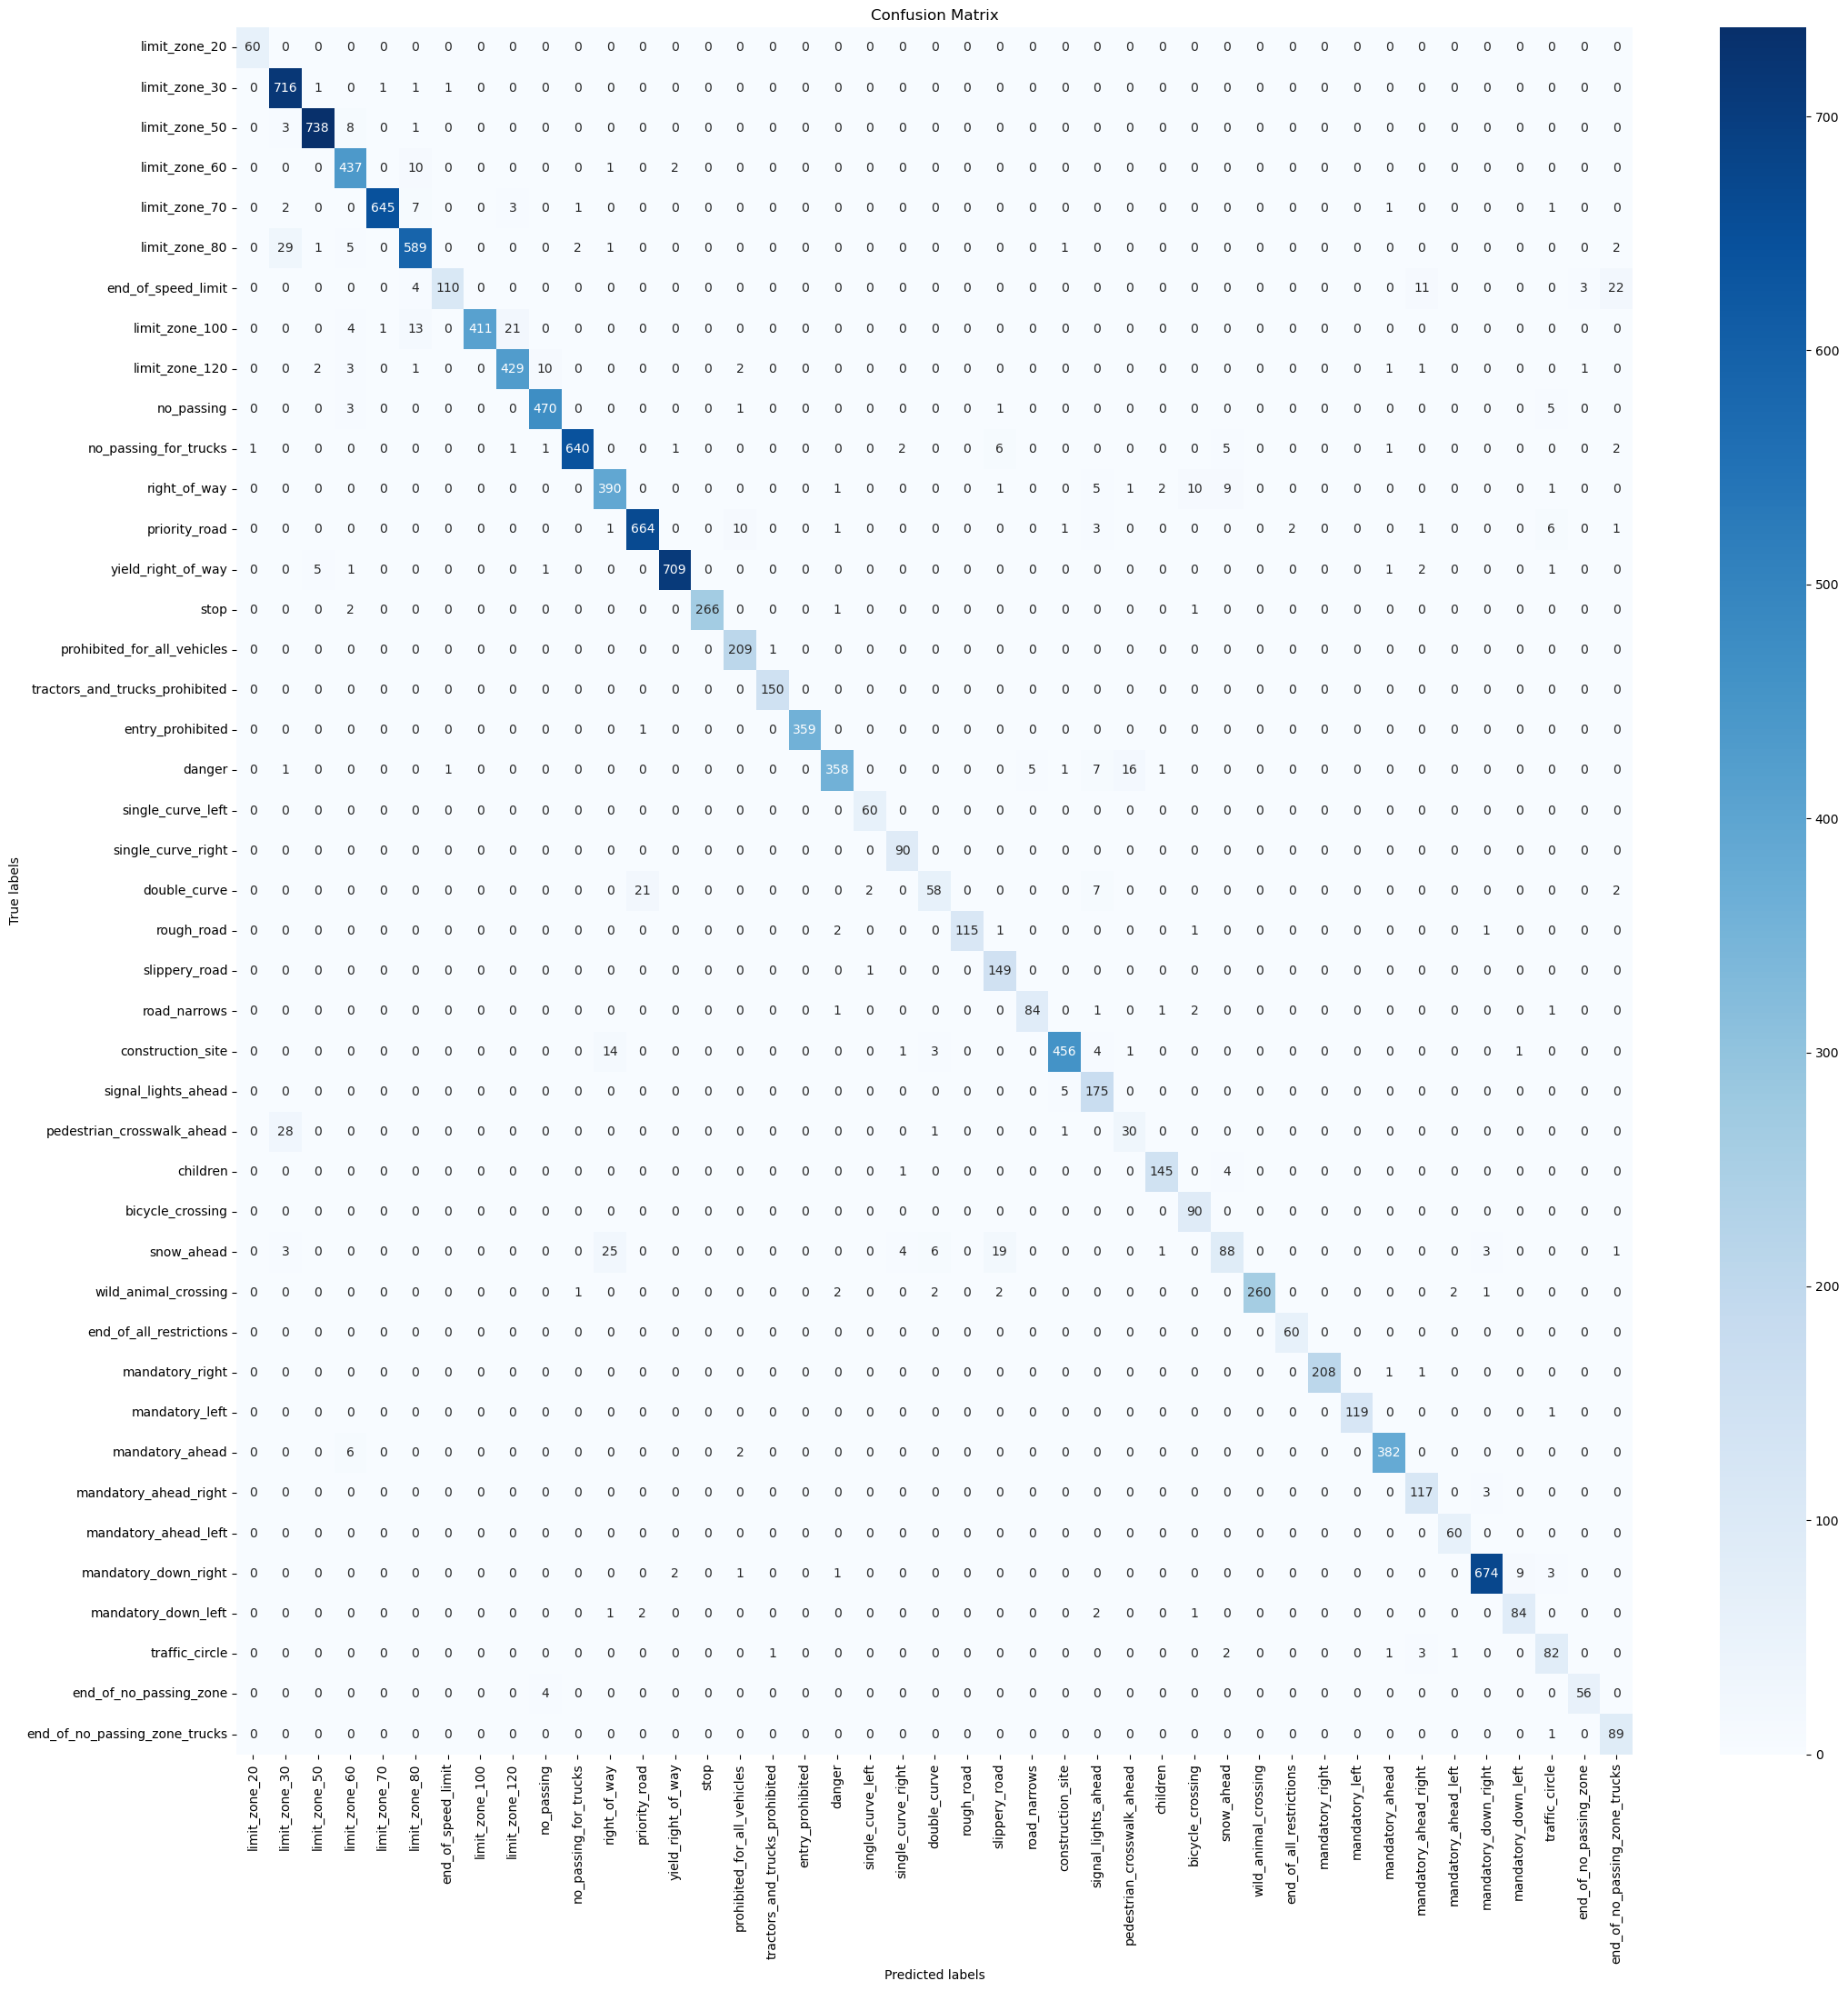

In [37]:
plot_confusion_matrix(true_labels, y_preds, sign_names, save_figure=True,figsize=(22, 22),filename="confusion_simple_model")


In [38]:
end_time = datetime.datetime.now()

In [39]:
time_passed = (end_time-start_time).seconds/60

In [40]:
time_passed

9.116666666666667

In [41]:
print(f"This notebook took a total of : {time_passed:.2f} minutes to execute entirely")

This notebook took a total of : 9.12 minutes to execute entirely
